# Inicialização e Carregamento

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import fastparquet

In [2]:
dados_cadastrais_df = pd.read_csv("dados_cadastrais_fake.csv",sep=";")

In [3]:
dados_cadastrais_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   nomes   10000 non-null  object
 1   idade   10000 non-null  int64 
 2   cidade  10000 non-null  object
 3   estado  10000 non-null  object
 4   cpf     10000 non-null  object
 5   cnpj    10000 non-null  object
dtypes: int64(1), object(5)
memory usage: 468.9+ KB


In [4]:
dados_cadastrais_df['cpf']

0          97566536800
1       425.263.807-07
2          34647754103
3       252.531.560-03
4          49668886542
             ...      
9995    744.822.622-34
9996       10683395190
9997    538.223.638-04
9998       11632512408
9999    192.134.492-08
Name: cpf, Length: 10000, dtype: object

In [5]:
dados_cadastrais_df['cnpj']

0           06589184909526
1       25.673.336/2350-20
2           26543101702989
3       19.062.080/5100-98
4           97794530015384
               ...        
9995    16.740.076/9329-75
9996        32246978843482
9997    86.601.303/7580-88
9998        08651414023648
9999    08.908.871/5161-91
Name: cnpj, Length: 10000, dtype: object

In [6]:
dados_cadastrais_df['cnpj']

0           06589184909526
1       25.673.336/2350-20
2           26543101702989
3       19.062.080/5100-98
4           97794530015384
               ...        
9995    16.740.076/9329-75
9996        32246978843482
9997    86.601.303/7580-88
9998        08651414023648
9999    08.908.871/5161-91
Name: cnpj, Length: 10000, dtype: object

## Função de Substituição de Caracteres em Data Frames por Espaço em Branco

In [7]:
def substitui_caracteres(df, coluna, lista):
    for item in lista:
        df[coluna] = df[coluna].replace(to_replace=item, value='', regex=True)

# Normalização

## Normalização de nome: adequação de referências e siglas

In [8]:
caracteres = ['Dr.', 'Mr.', 'Mrs.', 'DDS', 'MD', 'PhD', 'DVM', 'II', 'III', 'IV']

In [9]:
coluna = 'nomes'

In [10]:
substitui_caracteres(dados_cadastrais_df, coluna, caracteres)

In [11]:
dados_cadastrais_df['nomes'] = dados_cadastrais_df['nomes'].replace("Jr.", "Junior", regex=True)\

In [12]:
dados_cadastrais_df['nomes']

0            Dennis Daniels
1               Leah Becker
2                Sally Ford
3            Colleen Duncan
4           Jeff Stephenson
               ...         
9995      Rebekah Mitchell 
9996    Lisa Parrish Junior
9997         Michael Young 
9998          Kevin Watson 
9999         Joseph Wilson 
Name: nomes, Length: 10000, dtype: object

## Normalização de nome: letras maiusculas e minusculas, e trim.

In [13]:
def normaliza_nome(nome):
    nome_final = ''
    
    sep = ' '
    
    for item in nome.split(' '):
        nome_final = nome_final + sep + item.capitalize()
        
    nome_final = nome_final.strip()
    
    return nome_final

In [14]:
dados_cadastrais_df['nomes'] = dados_cadastrais_df['nomes'].map(lambda nome: normaliza_nome(nome))

## Normalização de nomes de cidades: palavras que componhem a cidade começando com maiúsculo

In [15]:
dados_cadastrais_df['cidade'] = dados_cadastrais_df['cidade'].map(lambda nome: normaliza_nome(nome))

In [16]:
dados_cadastrais_df['cidade']

0            Acrelândia
1           Água Branca
2              Alvarães
3        Serra Do Navio
4                Abaíra
             ...       
9995            Abaiara
9996           Brasília
9997     Afonso Cláudio
9998    Abadia De Goiás
9999         Açailândia
Name: cidade, Length: 10000, dtype: object

## Normalização de estados: apenas siglas

In [17]:
dados_cadastrais_df['estado'] = dados_cadastrais_df['estado'].apply(lambda x: x.strip())

In [18]:
dados_cadastrais_df['estado'] = dados_cadastrais_df['estado']\
                                        .replace('MINAS GERAI', 'MG')\
                                        .replace('MINAS GERAIs', 'MG')\
                                        .replace('distrito federal', 'DF')\
                                        .replace('rio de  janeiro', 'RJ')\
                                        .replace('são  paulo', 'SP', regex=True)\
                                        .replace('sao  paulo', 'SP', regex=True)

## COLUNAS DE CPF E CNPJ SEM CARACTERES ESPECIAIS

In [19]:
dados_cadastrais_df['cpf'] = dados_cadastrais_df['cpf'].replace('\.', '', regex=True)
dados_cadastrais_df['cpf'] = dados_cadastrais_df['cpf'].replace('-', '', regex=True)

In [20]:
dados_cadastrais_df['cpf'][1]

'42526380707'

In [21]:
dados_cadastrais_df['cnpj'] = dados_cadastrais_df['cnpj'].replace('\.', '', regex=True)
dados_cadastrais_df['cnpj'] = dados_cadastrais_df['cnpj'].replace('-', '', regex=True)
dados_cadastrais_df['cnpj'] = dados_cadastrais_df['cnpj'].replace('/', '', regex=True)

In [22]:
dados_cadastrais_df['cnpj'][2]

'26543101702989'

## FUNÇÕES DE VALIDAÇÃO DE CPF E CNPJ

In [23]:
def cpf_valido(cpf):
    tamanho_cpf = 11
    if len(cpf) != tamanho_cpf:
        return False

    if cpf in (c * tamanho_cpf for c in "1234567890"):
        return False

    cpf_reverso = cpf[::-1]
    for i in range(2, 0, -1):
        cpf_enumerado = enumerate(cpf_reverso[i:], start=2)
        dv_calculado = sum(map(lambda x: int(x[1]) * x[0], cpf_enumerado)) * 10 % 11
        if cpf_reverso[i - 1:i] != str(dv_calculado % 10):
            return False

    return True

In [24]:
def cnpj_valido(cnpj):
    tamanho_cnpj = 14
    if len(cnpj) != tamanho_cnpj:
        return False

    if cnpj in (c * tamanho_cnpj for c in "1234567890"):
        return False

    cnpj_r = cnpj[::-1]
    for i in range(2, 0, -1):
        cnpj_enum = zip(cycle(range(2, 10)), cnpj_r[i:])
        dv = sum(map(lambda x: int(x[1]) * x[0], cnpj_enum)) * 10 % 11
        if cnpj_r[i - 1:i] != str(dv % 10):
            return False

    return True

## CRIAÇÃO DE COLUNAS DE CPF_VALIDO E CNPJ_VALIDO 

In [25]:
dados_cadastrais_df['cpf_valido'] = dados_cadastrais_df['cpf'].apply(cpf_valido)

In [26]:
dados_cadastrais_df['cnpj_valido'] = dados_cadastrais_df['cnpj'].apply(cnpj_valido)

## Pergunta 1: Quantos clientes temos nessa base?

In [27]:
dados_cadastrais_df.count()

nomes          10000
idade          10000
cidade         10000
estado         10000
cpf            10000
cnpj           10000
cpf_valido     10000
cnpj_valido    10000
dtype: int64

## Pergunta 2: Qual a média de idade dos clientes?

In [28]:
media = dados_cadastrais_df['idade'].mean()

In [29]:
print(f"A média de idade é de {media} anos")

A média de idade é de 53.7831 anos


## Pergunta 3: Quantos clientes nessa base pertencem a cada estado?

In [30]:
estados_contagem_df = dados_cadastrais_df.groupby(['estado'])['estado'].count()

In [31]:
estados_contagem_df

estado
AC    371
AL    371
AM    371
AP    371
BA    371
CE    371
DF    371
ES    371
GO    371
MA    371
MG    370
MS    370
MT    370
PA    370
PB    370
PE    370
PI    370
PR    370
RJ    370
RN    370
RO    370
RR    370
RS    370
SC    370
SE    370
SP    370
TO    370
Name: estado, dtype: int64

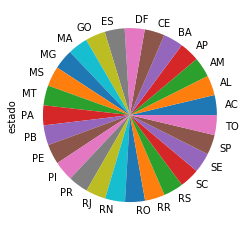

In [32]:
estados_contagem_df.plot.pie(subplots=True, figsize=(8, 4));

## Pergunta 4: Quantos CPFs válidos e inválidos foram encontrados?

In [33]:
cpfs_validos = dados_cadastrais_df['cpf_valido']

In [34]:
cpfs_validos

0       True
1       True
2       True
3       True
4       True
        ... 
9995    True
9996    True
9997    True
9998    True
9999    True
Name: cpf_valido, Length: 10000, dtype: bool

In [35]:
num_cpfs_validos = cpfs_validos.where(cpfs_validos == True).count()

In [36]:
print(f"Numeros de cpfs validos é {num_cpfs_validos}")

Numeros de cpfs validos é 10000


## Pergunta 5: Quantos CPFs válidos e inválidos foram encontrados?

In [37]:
cnpjs_validos = dados_cadastrais_df['cnpj_valido']

In [38]:
num_cnpj_validos = cnpjs_validos.where(cnpjs_validos == True).count()

In [39]:
print(f"Numeros de cnpj validos é {num_cnpj_validos}")

Numeros de cnpj validos é 10000


## Carregamento em CSV

In [40]:
dados_cadastrais_df.to_csv('problema1_normalizado.csv', sep=';', index=False)

In [41]:
dados_cadastrais_df.to_parquet('problema1_normalizado.parquet', engine='fastparquet', index=False)